# 1. Business problem
---

## 1.1. Context

The company's CFO held a meeting with all store managers and asked each of them to bring a daily forecast for the next 6 weeks of sales.

After this meeting, all managers contacted you, requesting a sales forecast for your store.

**Note:** The data was made available [here](https://www.kaggle.com/c/rossmann-store-sales).

## 1.2. Understanding the problem

### 1.2.1. Motivation

The CFO requested this solution during a monthly results meeting.

### 1.2.2. Root cause of the problem

Difficulty in determining the investment value for renovations in each store.

### 1.2.3. Who is the Stakeholder

The CFO.

### 1.2.4. Solution format

- Granularity and problem type: daily sales forecast in cash for the next 6 weeks;
- Potential resolution methods: Time Series, Regression, Neural Networks;
- Delivery format:
    1. The total sales amount at the end of 6 weeks;
    2. Possibility of checking the value by cell phone.

# 2. Imports
---

## 2.1. Libraries

In [36]:
import math
import pandas as pd
import inflection
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

plt.style.use('ggplot')
%matplotlib inline

## 2.2. Helper Functions

In [2]:
def change_cols_to_snake_case(df):
    '''
    Change a list of columns of dataframe from 
    camel case to snake case.
    This function returns the modified dataframe.
    '''
    cols = df.columns
    snake_case = lambda x: inflection.underscore(x)
    new_cols = list(map(snake_case, cols))
    df.columns = new_cols
    return df

def check_nan_on_df_columns(df):
    '''
    Only check the NaN values on
    the dataframe columns.
    '''
    print(df.isna().sum())
    return None

def fillout_nan_on_col_with(time, col, df):
    '''
    According to "date" column on dataframe, this function fills NaN on certain attribute with
    the wanted time type. The time should be "year", "month" or "week".
    The function returns the modified dataframe.
    '''
    if time == 'year':
        df[col] = df.apply(lambda x: x['date'].year if math.isnan(x[col]) else x[col], axis=1)
        return df
    elif time == 'month':
        df[col] = df.apply(lambda x: x['date'].month if math.isnan(x[col]) else x[col], axis=1)
        return df
    elif time == 'week':
        df[col] = df.apply(lambda x: x['date'].week if math.isnan(x[col]) else x[col], axis=1)
        return df
    else:
        print('Unrecognized time...')
        return None
    
def show_histplot(x, data, title=None, xlabel=None):
    '''
    Show the histplot, given a x, data, 
    title and x label values.
    '''
    plt.figure(figsize=(16, 8))
    sns.histplot(x=x, data=data, kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

## 2.3. Loading Data

In [3]:
# Loading the sales df
df_sales = pd.read_csv('data/train.csv', low_memory=False)
display(df_sales.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
# Loading the store df
df_store = pd.read_csv('data/store.csv', low_memory=False)
display(df_store.head())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
# Merging the sale and store df's
df = pd.merge(df_sales, df_store, how='left', on='Store')
display(df.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 3. Data Description
---

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- `Id` - an Id that represents a (Store, Date) duple within the test set.

- `Store` - a unique Id for each store.

- `Sales` - the turnover for any given day (this is what you are predicting).

- `Customers` - the number of customers on a given day.

- `Open` - an indicator for whether the store was open. 
    - 0 = closed; 
    - 1 = open.

- `StateHoliday` - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends: 
    - a = public holiday;
    - b = Easter holiday;
    - c = Christmas;
    - 0 = None.

- `SchoolHoliday` - indicates if the (Store, Date) was affected by the closure of public schools.

- `StoreType` - differentiates between 4 different store models: a, b, c, d.

- `Assortment` - describes an assortment level:
    - a = basic;
    - b = extra;
    - c = extended.

- `CompetitionDistance` - distance in meters to the nearest competitor store.

- `CompetitionOpenSince[Month/Year]` - gives the approximate year and month of the time the nearest competitor was opened.

- `Promo` - indicates whether a store is running a promo on that day.

- `Promo2` - Promo2 is a continuing and consecutive promotion for some stores: 
    - 0 = store is not participating;
    - 1 = store is participating.

- `Promo2Since[Year/Week]` - describes the year and calendar week when the store started participating in Promo2.

- `PromoInterval` - describes the consecutive intervals Promo2 is started, naming the months the promotion is started a new. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store.

## 3.1. Rename Columns

I'll rename the camel case columns to snake case in this section. Because my programming style is with snake case.

In [6]:
# Showing the old columns
print('Old columns:')
print(df.columns, '\n')

Old columns:
Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object') 



In [7]:
# Changing columns to snake case
print('New columns:')
df = change_cols_to_snake_case(df)
print(df.columns)

New columns:
Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')


## 3.2. Data Dimensions

In [8]:
print(f'Number of rows: {df.shape[0]};')
print(f'Number of columns: {df.shape[1]}.')

Number of rows: 1017209;
Number of columns: 18.


## 3.3. Data Types

In [9]:
# Original data types
print(df.dtypes)

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object


Working with datetime type rather than object is easier! So, I'll change that!

In [10]:
# Changing the date type to datetime
df['date'] = pd.to_datetime(df['date'])
print(df.dtypes)

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object


## 3.4. Check NaN

In [11]:
check_nan_on_df_columns(df)

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64


There are a lot of NaN values on the last columns. It is highly recommended to fill that lines with some number, or at least, drop them, because we need to do this to run the machine learning algorithms in the future.

## 3.5. Fill out NaN

### 3.5.1. competition_distance

Maybe people didn't fill out this column because the distances to the nearest competitor stores aren't to be considered. In other words, the `competition_distance` of that store is too far!

Therefore, we only need to replace the NaN values for huge distances. The question is, what is a "huge distances"? 

Let's see the highest value on this column.

In [12]:
max_value = df['competition_distance'].max()
print(f'The max value of this attribute is: {max_value}.')

The max value of this attribute is: 75860.0.


So, we only need to replace the NaN for a huge distance, like... **200,000.0**.

In [13]:
df['competition_distance'] = df['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
check_nan_on_df_columns(df)

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64


### 3.5.2. competition_open_since_month

Why this column has NaN? There are two reasons that I suppose:

1. The store doesn't have a nearest competitor, so there isn't an opening date;

2. There is a nearest competitor, but we don't know when is the opening date.

My solution to fill NaN on this column is to work with the actual month. I don't want to exclude this variable because it seems to be important to our analysis and maybe for machine learning algorithms...

In [14]:
df = fillout_nan_on_col_with('month', 'competition_open_since_month', df)

### 3.5.3. competition_open_since_year

The same logic above I'll apply to this attribute.

In [15]:
df = fillout_nan_on_col_with('year', 'competition_open_since_year', df)

In [16]:
# Checking if we did it right
check_nan_on_df_columns(df)

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64


Yep, we did it!

### 3.5.4. promo2_since_week

If the value is NaN on this column, it's because the store has not decided to participate on promo2. So, we don't know exactily what value to replace in this case, as well as the variables above!

Therefore, I'll replace the NaN with the current week, like the variables above.

In [17]:
df = fillout_nan_on_col_with('week', 'promo2_since_week', df)

### 3.5.5. promo2_since_year

The same logic above I'll apply to this attribute.

In [18]:
df = fillout_nan_on_col_with('year', 'promo2_since_year', df)

In [19]:
# Checking if we did it right
check_nan_on_df_columns(df)

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week                    0
promo2_since_year                    0
promo_interval                  508031
dtype: int64


### 3.5.6. promo_interval

To fill NaN values on this column, I think the best option is to replace with zeros. That is because maybe the promo2 doesn't exist for that store, so we don't have any `promo_interval`!

In [20]:
df['promo_interval'].fillna(0, inplace=True)

In [21]:
# Checking if we did it right
check_nan_on_df_columns(df)

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
dtype: int64


Okay, we're almost done.

Look at the variable `promo_interval`. Maybe we can create another variable based on that, like if the current month of the store is on promo2! So, we can create an attribute called `is_promo` to signal this fact.

In [22]:
# Mapping the current number of the month to 3 first letter of the month
month_map = {1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr',
             5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug',
             9 : 'Sep', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}

# Creating the month_map column, based on the map dict created above
df['month_map'] = df['date'].dt.month.map(month_map)
df.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul


In [23]:
# Creating the is_promo column
## If the promo_interval is 0, then do nothing
## Else the promo_interval has a string, then verify if the month_map is on that string
df['is_promo'] = df.apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [24]:
# Looking to the final dataframe
df.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0


## 3.6. Change data types

On this section, I'll look to the columns type and make some modifications, maybe.

In [25]:
print(df.dtypes)

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object


We can see that `competition_open_since_month`, `competition_open_since_year`, `promo2_since_week` and `promo2_since_year` are float types, and the correct type of them is integer. let's change it!

In [26]:
wanted_cols = ['competition_open_since_month', 'competition_open_since_year', 
               'promo2_since_week', 'promo2_since_year']

for col in wanted_cols:
    df[col] = df[col].astype('int64')

print(df.dtypes)

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object


## 3.7. Descriptive Statistics

Before we start, I want to separate the numerical and categorical variables, just because the analysis to these sets are different.

In [27]:
num_attributes = df.select_dtypes(include=['int64', 'float64'])
print('Numerical attributes:')
display(num_attributes)
cat_attributes = df.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
print('Categorical attributes:')
display(cat_attributes)

Numerical attributes:


,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,0,0,0,0,1,1900.0,6,2014,1,31,2013,1
1017205,1112,2,0,0,0,0,1,1880.0,4,2006,0,1,2013,0
1017206,1113,2,0,0,0,0,1,9260.0,1,2013,0,1,2013,0
1017207,1114,2,0,0,0,0,1,870.0,1,2013,0,1,2013,0


Categorical attributes:


,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul
...,...,...,...,...,...
1017204,a,a,a,"Jan,Apr,Jul,Oct",Jan
1017205,a,c,c,0,Jan
1017206,a,a,c,0,Jan
1017207,a,a,c,0,Jan


Let's see how is the sales distribution and some statistics of the variables on numerical section and how is the categorical sales boxplots on categorical section.

### 3.7.1. Numerical Attributes

In [28]:
# Creating the metrics dataframe
metrics = num_attributes.describe().T.drop(['count', '25%', '75%'], axis=1)
metrics.rename({'50%' : 'median'}, inplace=True, axis=1)

# Creating the skewness and kurtosis of each variables
skews = num_attributes.apply(lambda x: x.skew()).T
kurtosis = num_attributes.apply(lambda x: x.kurtosis()).T

# Creating the range of min and max values
metrics['range'] = metrics['max'] - metrics['min']

# Adding the skews and kurthosis values on metrics dataframe
metrics['skew'] = skews
metrics['kurtosis'] = kurtosis

# Changing the index to a variable and renaming it
metrics.reset_index(inplace=True)
metrics.rename({'index':'attribute'}, axis=1, inplace=True)

# Changing the order of columns apresentation on dataframe
metrics = metrics[['attribute', 'min', 'max', 'range', 'mean', 'median', 
                   'std', 'skew', 'kurtosis']]
display(metrics)

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908651,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997391,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.926175,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411734,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485759,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.652996,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311087,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515593,-7.235657,124.071304


Look at the `competition_open_since_year` variable. It has a high skew and kurtosis, and it's okay, because we fill out the 323,348 NaN with the current year. So, it doesn't matter.

One variable that catch our attention is the `competition_distance`, because it has the highest skew and kurtosis values. A conclusion for this is that most stores have a very near competitor.

Let's have a look at the `competition_distance` distribution.

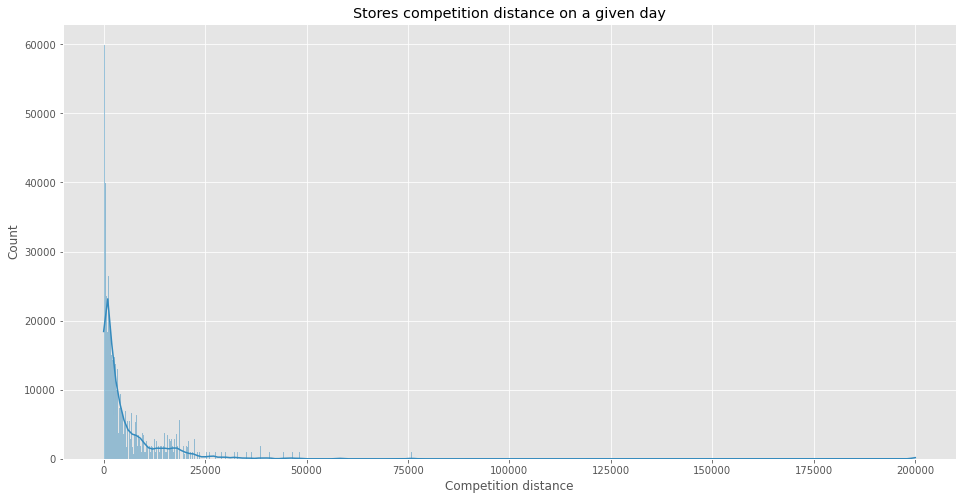

In [30]:
# Showing the stores competition distance count on a given day distribution
show_histplot('competition_distance', df, 
              'Stores competition distance on a given day', 
              'Competition distance')

Yep, it confirmed our theory.

Now, I want to see the stores sales distribution, our target for machine learning.

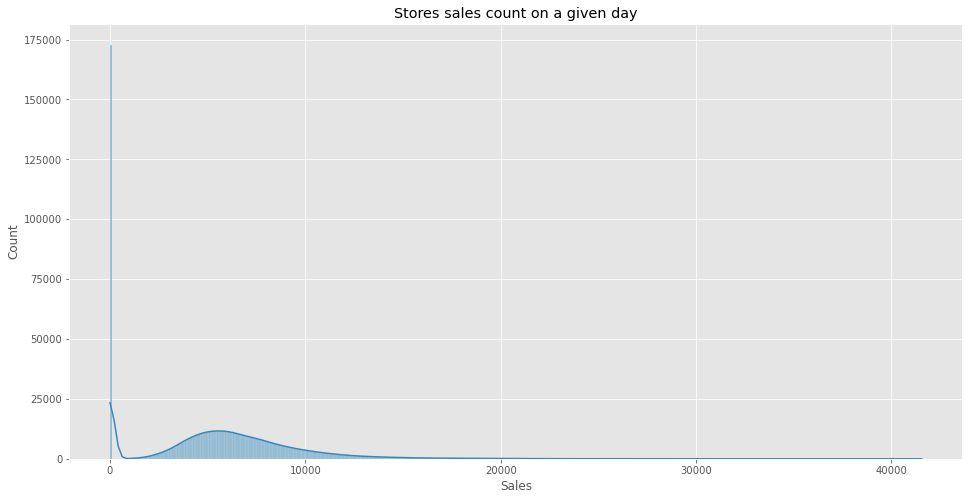

In [32]:
# Showing the stores sales count on a given day distribution
show_histplot('sales', df, 
              'Stores sales count on a given day', 
              'Sales')

The curve looks like a **normal distribution**, if we drop the zeros... Maybe, this is an important information.

### 3.7.2. Categorical Attributes

In [33]:
# Some conditions that I want to apply
aux_df = df[(df['state_holiday'] != '0') & (df['sales'] > 0)]

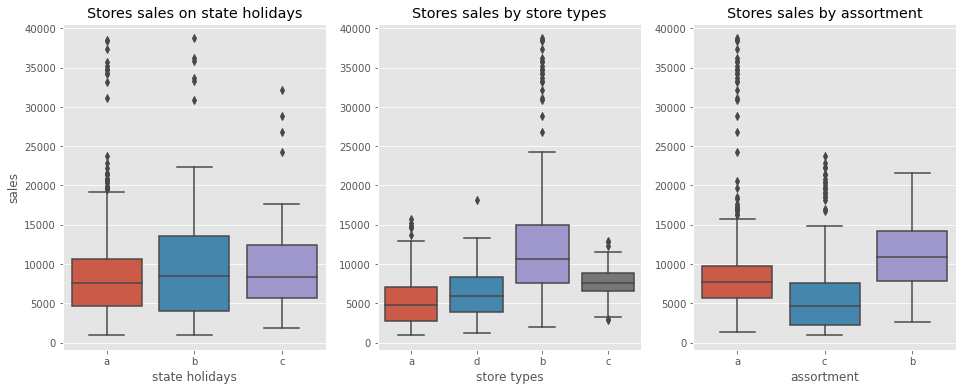

In [34]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.title('Stores sales on state holidays')
sns.boxplot(x='state_holiday', y='sales', data=aux_df)
plt.xlabel('state holidays')

plt.subplot(1, 3, 2)
plt.title('Stores sales by store types')
sns.boxplot(x='store_type', y='sales', data=aux_df)
plt.xlabel('store types')
plt.ylabel('')

plt.subplot(1, 3, 3)
plt.title('Stores sales by assortment')
sns.boxplot(x='assortment', y='sales', data=aux_df)
plt.ylabel('');

- The **state holiday**, **store type** and **assortment b** have the highest dispersions of stores sales;
- the **store type** and **assortment b** have the highest median of stores sales.

# 4. Feature Engineering
---

## 4.1. Mind Map

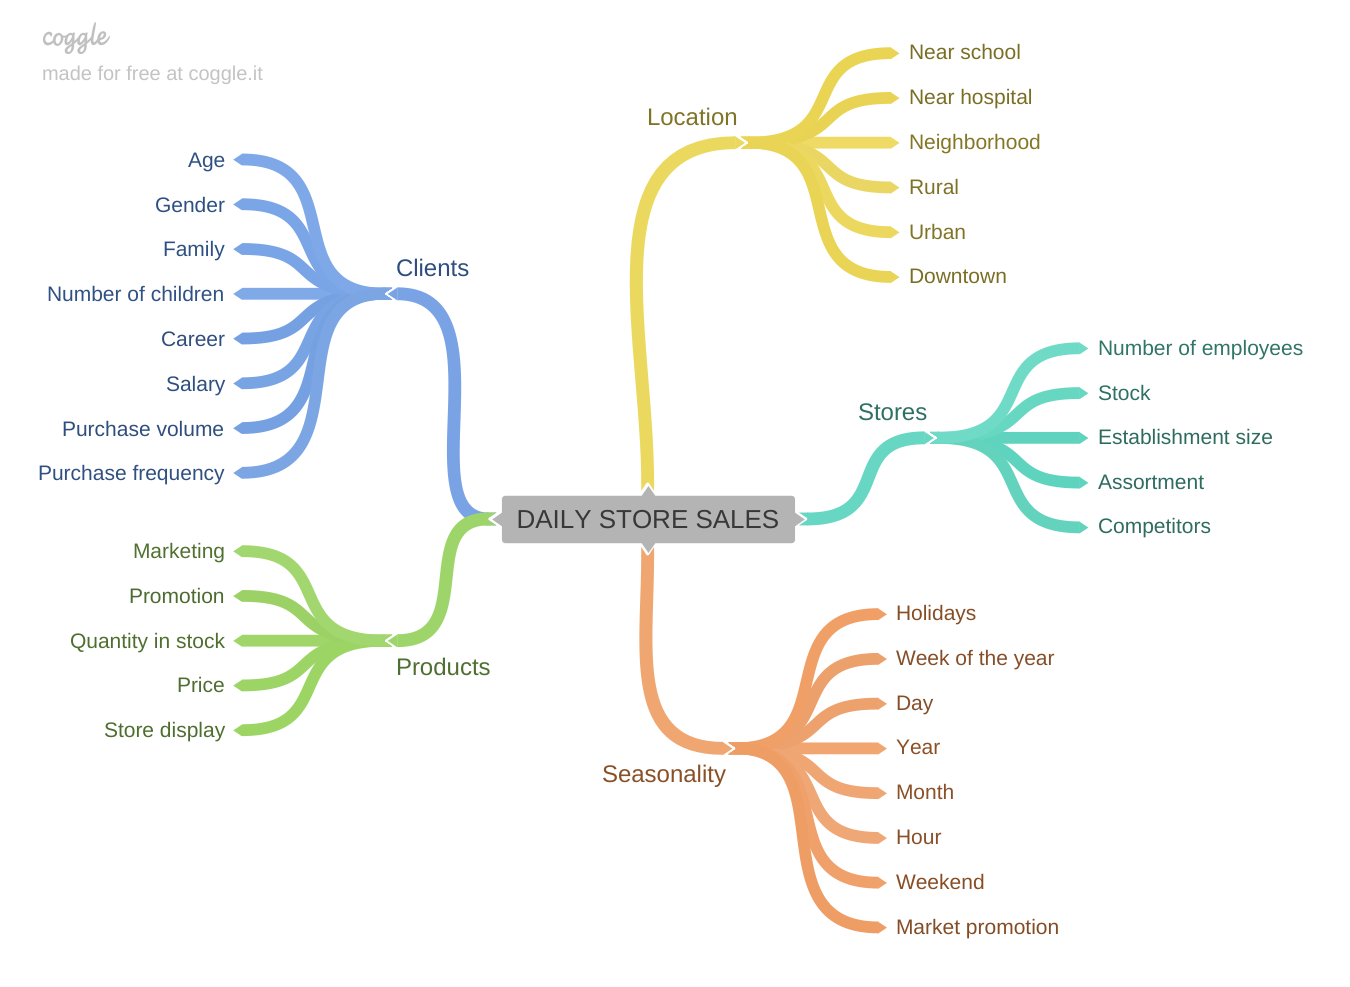

In [37]:
Image('img/mind_map_hypothesis.png')